In [4]:
import sys
import os
import glob
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'
from scipy.stats import norm, skew, kurtosis
import matplotlib.mlab as mlab
plt.style.use('JFM')

import scripts.statistics as stats
import scripts.get_namelist as nml
from scripts.hh_decomp import window_tukey, window_field
from scripts.common import *

du = {# U_L/du
0.2:[0.320878628692,0.014354985748],
0.4:[0.28759238955,0.0173941871764],
0.8:[0.179652184681,0.012733736384],
1.2:[0.152164204092,0.0106738755021],
1.6:[0.144804252876,0.00974592070867],
2.0:[0.142805206381,0.0110827643436],
}

du_s7 = {
0.2:[0.212809887078,0.0174258713457],
0.8:[0.191486082107,0.0119116965823],
2.0:[0.137051163804,0.0110047225507],
}

U_L = {}
for key in du.keys():
    U_L[key] = key*du[key][0]
U_L_s7 = {}
for key in du_s7.keys():
    U_L_s7[key] = key*du_s7[key][0]

def get_data(f):
    dat = np.fromfile(f,sep=' ')
    n = np.size(dat)
    dat = np.reshape(dat,[int(n/6.),6])
    ubar = dat[:,0]
    vbar = dat[:,1]
    utilde = dat[:,2]
    vtilde = dat[:,3]
    ru = dat[:,4]
    rv = dat[:,5]
    return ubar,vbar,utilde,vtilde,ru,rv

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/512x724x256/'
directory = '/home/kmatsuno/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"massflux*dat")
flist.sort()
print([f.split('/')[-1] for f in flist])

tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['massflux_0006.dat', 'massflux_0007.dat', 'massflux_0008.dat', 'massflux_0009.dat', 'massflux_0010.dat', 'massflux_0011.dat', 'massflux_0012.dat', 'massflux_0013.dat']


0.8: [0.00670179073297,0.000701503432939],
0.8: [0.00444273642624,0.000273847474605],


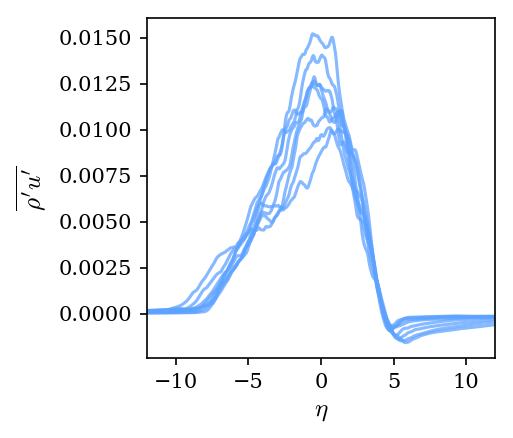

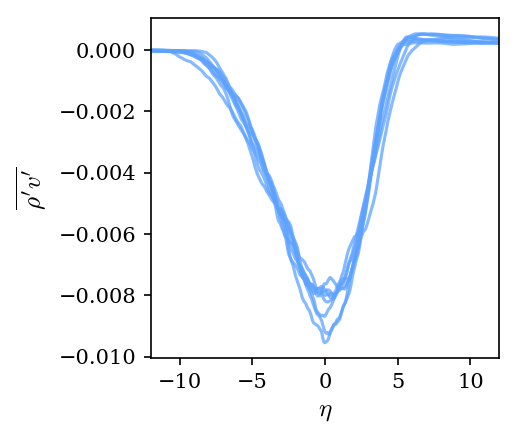

In [3]:
s = '7'
Mc_list = ['08']#['02','08','20']
# Mc_list = ['02','04','08','12','16','20']

jet = cm = plt.get_cmap('cool') 
cNorm  = matplotlib.colors.Normalize(vmin=0, vmax=2.2)
scalarMap = matplotlib.cm.ScalarMappable(norm=cNorm, cmap=jet)

for comp in ['u','v']:
    fig = plt.figure(figsize=(3,3),dpi=150)
    for i,Mc in enumerate(Mc_list):
        directory = '/home/kmatsuno/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
        filename_prefix = directory + '/shearlayer_'
        inp = nml.inputs(directory)
        Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
        Ny = int(Ny)
        y = np.linspace(-Ly/2.,Ly/2.,Ny)

        flist = glob.glob(directory+"massflux*")
        flist.sort()

        if Mc=='08': ist = 5;ien=-1
        elif Mc=='12': ist = 5;ien=None
        elif Mc=='16': ist = 3;ien=-1
        else: ist=0;ien = -1
        mat = np.zeros([len(flist[ist:ien])])

     
        colorVal = scalarMap.to_rgba(inp.Mc)
        for j,fname in enumerate(flist[ist:ien]):
            tID = fname.split('/')[-1]
            tID = tID.split('_')[-1]
            tID = int(tID.split('.')[0])
            time = nml.read_time(directory,tID)

            # Get dtheta
            dtheta = get_dtheta(directory,time)
            eta = y/dtheta

            scale = 1./inp.du#U_L[inp.Mc]
            ubar,vbar,utilde,vtilde,ru,rv = get_data(fname)
            if comp=='u': fplot = ru*scale
            if comp=='v': fplot = rv*scale
            if j==0: plt.plot(eta,fplot,alpha=0.75,color=colorVal,label='$M_c$ = {}'.format(inp.Mc))
            else: plt.plot(eta,fplot,alpha=0.75,color=colorVal)
            mat[j] = 0.5*(abs(min(fplot))+abs(max(fplot))) # avg of peak magnitudes
            
        mn = np.mean(mat,axis=0)
        std = np.std(mat,axis=0)
        print('{}: [{},{}],'.format(inp.Mc,mn,std))
#     plt.plot(eta_plot,mn,color='C%i'%i)
#     plt.fill_between(eta_plot, mn-std, mn+std, color='C%i'%i, alpha=0.2)

    plt.xlim([-12,12])
    plt.xlabel(r'$\eta$')
    plt.ylabel(r"$\overline{\rho'%s'}$"%comp)
# plt.legend(fontsize=9)

In [90]:
# Scaled by U_delta (U_L)
ru = {
0.2: [0.00154097162925,8.12362182695e-05],
0.4: [0.00474205869084,0.00174612720394],
0.8: [0.0235862537818,0.00108652634828],
1.2: [0.0496339286951,0.00171375231737],
1.6: [0.0665813298017,0.00549517205812],
2.0: [0.0932230804929,0.014861135571],}
rv = {
0.2: [0.000926963400957,7.1915203116e-05],
0.4: [0.00214301182672,0.000923312239401],
0.8: [0.0101560719283,0.000933407119072],
1.2: [0.020104929885,0.00117614622171],
1.6: [0.0232079445747,0.00319566380981],
2.0: [0.0292090768354,0.00347633996227],
}

In [92]:
ru={
0.2: [0.000208949541493,1.10153037459e-05],
0.4: [0.000576302230651,0.000212206779426],
0.8: [0.00179059536707,8.24857166142e-05],
1.2: [0.00319151682057,0.000110196180133],
1.6: [0.00407417583556,0.000336254882234],
2.0: [0.00562565995446,0.000896813265746],
}
rv = {
0.2: [0.000125692500715,9.75141166279e-06],
0.4: [0.00026044015407,0.000112210104903],
0.8: [0.000771017538893,7.08613787702e-05],
1.2: [0.00129276935337,7.5627510228e-05],
1.6: [0.00142011652907,0.00019554575301],
2.0: [0.0017626571981,0.0002097839549],
}

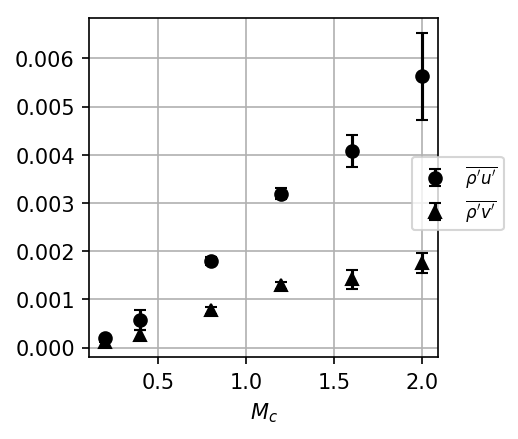

In [93]:
def plotter(dat,fmt,label):
    plt.errorbar(dat.keys(),[x[0] for x in dat.values()],
        yerr=[x[1] for x in dat.values()],fmt=fmt,capsize=3,label=label)

fig = plt.figure(figsize=(3,3),dpi=150)
plotter(ru,'ko',r'$\overline{\rho^\prime u^\prime}$')
plotter(rv,'k^',r'$\overline{\rho^\prime v^\prime}$')

plt.xlabel('$M_c$')
plt.grid(True)
# plt.ylim([-0.9,0.9])
# plt.ylim([-.023,0.023])
plt.legend(fontsize=8,bbox_to_anchor=(0.9,0.35))

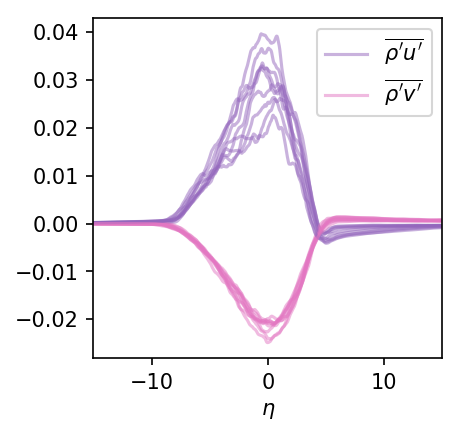

In [9]:
s = '7'
Mc='08'

fig = plt.figure(figsize=(3,3),dpi=150)

directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
filename_prefix = directory + '/shearlayer_'
inp = nml.inputs(directory)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"massflux*")
flist.sort()

ist = 5;ien=None
        
for j,fname in enumerate(flist[ist:ien]):
    tID = fname.split('/')[-1]
    tID = tID.split('_')[-1]
    tID = int(tID.split('.')[0])
    time = nml.read_time(directory,tID)

    # Get dtheta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta

    ubar,vbar,utilde,vtilde,ru,rv = get_data(fname)
    if j==0: 
        label1=r"$\overline{\rho'u'}$"
        label2=r"$\overline{\rho'v'}$"
    else: 
        label1=None
        label2=None
    plt.plot(eta,ru,color='C4',alpha=0.5,label=label1)
    plt.plot(eta,rv,color='C6',alpha=0.5,label=label2)

plt.xlim([-15,15])
plt.xlabel(r'$\eta$')
# plt.ylabel(r"$\overline{\rho'%s'}$"%comp)
plt.legend()
# plt.grid(True)


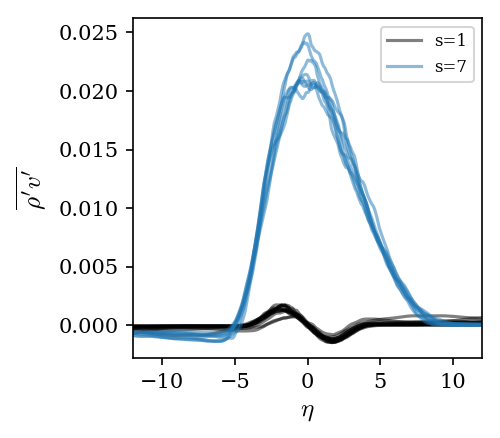

In [6]:
s_list = ['1','7']
colors=['k','C0']
Mc = '08'
fig = plt.figure(figsize=(3,3),dpi=150)

for i,s in enumerate(s_list):
    directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc%s/rr%s/1024x1448x512/'%(Mc,s)
    filename_prefix = directory + '/shearlayer_'
    inp = nml.inputs(directory)
    Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=False)
    Ny = int(Ny)
    y = np.linspace(-Ly/2.,Ly/2.,Ny)

    flist = glob.glob(directory+"massflux*")
    flist.sort()
#     mat = np.zeros([1,len(flist),100])
#     eta_plot = np.linspace(-20,20,100)

    if s=='7': ist = 5;ien=-1
    else: ist=1;ien = -1
        
    for j,fname in enumerate(flist[ist:ien]):
        tID = fname.split('/')[-1]
        tID = tID.split('_')[-1]
        tID = int(tID.split('.')[0])
        time = nml.read_time(directory,tID)

        # Get dtheta
        dtheta = get_dtheta(directory,time)
        eta = y/dtheta

        ubar,vbar,utilde,vtilde,ru,rv = get_data(fname)
        if j==0: label='s=%s'%s
        else: label=None
        plt.plot(-eta,-rv,color=colors[i],alpha=0.5,label=label)

plt.xlim([-12,12])
plt.xlabel(r'$\eta$')
plt.ylabel(r'$\overline{\rho^\prime v^\prime}$')
# plt.ylabel(r"$\overline{\rho'%s'}$"%comp)
plt.legend()
# plt.grid(True)
